In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import pandas as pd
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
import tensorflow as tf

# Configuration
base_dir = "/content/drive/MyDrive/Robotic Perception Project/event"  # Base directory containing 25 folders
csv_file = "/content/drive/MyDrive/Robotic Perception Project/event/labels.csv"  # CSV file with image paths and labels
# image_size = (128, 128)  # Resize all images to this size
batch_size = 32          # Batch size for training

# Load the labels CSV
labels_df = pd.read_csv(csv_file)

# Load images and their corresponding labels
def load_data(base_dir, labels_df):
    images = []
    labels = []

    for _, row in labels_df.iterrows():
        # Read the image
        image_path = row['name']  # Full path to the image
        image = cv2.imread(image_path)
        if image is None:
            print(f"Warning: Unable to load image {image_path}")
            continue

        # Resize and normalize the image
        # image = cv2.resize(image, image_size)
        image = image / 255.0  # Normalize to [0, 1]

        # Append image and corresponding label
        images.append(image)
        labels.append([row['labelx'], row['labely']])  # Labels: [cos(theta), sin(theta)]

    return np.array(images), np.array(labels)

# Load all data
images, labels = load_data(base_dir, labels_df, )

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    images, labels, test_size=0.2, random_state=42
)

print(f"Training data: {X_train.shape}, Testing data: {X_test.shape}")


In [ ]:
# pip install torchbnn

In [ ]:
!pip install snntorch==0.8.1 --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.2/125.2 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 64.7 MB/s eta 0:00:00


In [ ]:
# imports
import snntorch as snn
from snntorch import surrogate
from snntorch import backprop
from snntorch import functional as SF
from snntorch import utils
from snntorch import spikeplot as splt

import torch


import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np
import itertools

<ipython-input-4-b61fe04947fa>:4: DeprecationWarning: The module snntorch.backprop will be deprecated in  a future release. Writing out your own training loop will lead to substantially faster performance.
  from snntorch import backprop


In [ ]:
import torchbnn as bnn

In [ ]:
spike_grad = surrogate.fast_sigmoid(slope=25)
beta = 0.5

lif1 = snn.Leaky(beta=beta, spike_grad=spike_grad,threshold=0.9)

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [ ]:
data_divided = np.split(data_feature, 8, axis=1)
eval_divided = np.split(evaluation_feature, 8, axis=1)
train_temp=np.array(data_divided)
test_temp=np.array(eval_divided)
#print(data_divided.shape)
print(test_temp.shape)
print(test_temp[7,0,:])
print(train_temp[7,0,:])
test_temp = test_temp.transpose((1, 2, 0))
train_temp = train_temp.transpose((1, 2, 0))
data_temp=train_temp[:, None, :,:]
eval_temp=test_temp[:, None, :,:]

print(test_temp.shape[0])
print(train_temp.shape)
print(test_temp.shape)
print(data_temp.shape)
print(test_temp[0,:,7])

(8, 1221, 10)
[30.22685     0.05751888  0.11265574  0.13458434  0.1569126  28.965858
  0.05272282  0.10075134  0.11400593  0.13052285]
[12.229453    0.10719246  0.02622817  0.02871539  0.02667909 12.6077385
  0.10371684  0.02368496  0.02735129  0.02112327]
1221
(444, 10, 8)
(1221, 10, 8)
(444, 1, 10, 8)
[30.22685     0.05751888  0.11265574  0.13458434  0.1569126  28.965858
  0.05272282  0.10075134  0.11400593  0.13052285]


In [ ]:

train=torch.tensor(data_temp)
test=torch.tensor(eval_temp)
data_label=torch.tensor(data_label)
eval_label=torch.tensor(eval_label)
data_label = data_label.type(torch.LongTensor)
eval_label = eval_label.type(torch.LongTensor)

print(train.shape)
print(data_label.type())



torch.Size([444, 1, 10, 8])
torch.LongTensor


In [ ]:
from torch.utils.data import Dataset, DataLoader
class CustomDataset(Dataset):
    def __init__(self, train, data_label, transform=None):
        self.train = train
        self.data_label = data_label
        self.transform = transform

    def __len__(self):
        return len(self.train)

    def __getitem__(self, idx):
        sample = self.train[idx], self.data_label[idx]

        if self.transform:
            sample = self.transform(sample)

        return sample

# Create an instance of your custom dataset
custom_dataset = CustomDataset(train, data_label)
custom_dataset1 = CustomDataset(test, eval_label)

# Define a DataLoader to handle batching and shuffling
batch_size = 421 # Set your desired batch size
train_loader = DataLoader(custom_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(custom_dataset1, batch_size=batch_size, shuffle=True,drop_last=True)

In [ ]:
# neuron and simulation parameters
spike_grad = surrogate.fast_sigmoid(slope=25)
beta = 0.5
num_steps = 150

In [ ]:
# Define Network
class Net(nn.Module):
    def __init__(self):
        super().__init__()

        # Initialize layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding='same')
        self.lif1 = snn.Leaky(beta=beta, spike_grad=spike_grad)
        self.conv2 = nn.Conv2d(1, 32, kernel_size=3, padding='same')
        self.lif2 = snn.Leaky(beta=beta, spike_grad=spike_grad)
        self.conv3 = nn.Conv2d(1, 64, kernel_size=3, padding='same')
        self.lif3 = snn.Leaky(beta=beta, spike_grad=spike_grad)
        self.fc1 = bnn.BayesLinear(32*4*4, 6)
        self.lif4 = snn.Leaky(beta=beta, spike_grad=spike_grad)

    def forward(self, x):

        # Initialize hidden states and outputs at t=0
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        mem3 = self.lif3.init_leaky()
        mem4 = self.lif4.init_leaky()
        mem5 = self.lif5.init_leaky()

        cur1 = F.max_pool2d(self.conv1(x), 2)
        spk1, mem1 = self.lif1(cur1, mem1)

        cur2 = F.max_pool2d(self.conv2(spk1), 2)
        spk2, mem2 = self.lif2(cur2, mem2)

        cur3 = F.max_pool2d(self.conv3(spk2), 2)
        spk3, mem3 = self.lif3(cur3, mem3)


        # cur4 = self.fc1(spk3.view(batch_size, -1))
        # spk4, mem4 = self.lif3(cur3, mem3)
        cur4 = self.fc1(spk3.view(batch_size, -1))
        spk4, mem4 = self.lif4(cur4, mem4)
        return spk4, mem4

In [ ]:
#  Initialize Network
net = nn.Sequential(nn.Conv2d(1, 8, kernel_size=3, padding='same'),
                    nn.MaxPool2d(2),
                    snn.Leaky(beta=beta, spike_grad=spike_grad, threshold=1,init_hidden=True),
                    nn.Conv2d(8, 16, kernel_size=3, padding='same'),
                    nn.MaxPool2d(2),
                    snn.Leaky(beta=beta, spike_grad=spike_grad,threshold=1, init_hidden=True),
                    nn.Conv2d(16, 32, kernel_size=3, padding='same'),
                    nn.MaxPool2d(2),
                    snn.Leaky(beta=beta, spike_grad=spike_grad,threshold=1, init_hidden=True),
                    nn.Flatten(),
                    # nn.Linear(32*2, 64),
                    # snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True),
                    # nn.Linear(421, 6),
                    bnn.BayesLinear(prior_mu=0, prior_sigma=0.5, in_features=32, out_features=6),

                    # bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=32, out_features=6),
                    snn.Leaky(beta=beta, spike_grad=spike_grad, threshold=1,init_hidden=True, output=True)
                    ).to(device)

In [ ]:
data, targets = next(iter(train_loader))
data = data.to(device)
targets = targets.to(device)
print(data.shape)
print(targets.shape)

torch.Size([444, 1, 5, 16])
torch.Size([444])


In [ ]:

for step in range(num_steps):
    spk_out, mem_out = net(data)

In [ ]:
def forward_pass(net, num_steps, data):
  mem_rec = []
  spk_rec = []
  utils.reset(net)  # resets hidden states for all LIF neurons in net

  for step in range(num_steps):
      spk_out, mem_out = net(data)
      spk_rec.append(spk_out)
      mem_rec.append(mem_out)

  return torch.stack(spk_rec), torch.stack(mem_rec)

In [ ]:
spk_rec, mem_rec = forward_pass(net, num_steps, data)

In [ ]:
# already imported snntorch.functional as SF
loss_fn = SF.ce_rate_loss()
kl_loss = bnn.BKLLoss(reduction='mean', last_layer_only=True)
kl_weight = 0.5
#loss_fn = SF.ce_count_loss()

In [ ]:
loss_val = loss_fn(spk_rec, targets)
Kloss=kl_loss(net)
#loss_val = loss_fn1(spk_rec, targets)
print(f"The loss from an untrained network is {loss_val.item():.3f}")
print(f"The loss1 from an untrained network is {Kloss.item():.3f}")

The loss from an untrained network is 1.804
The loss1 from an untrained network is 0.010


In [ ]:
acc = SF.accuracy_rate(spk_rec, targets)
# acc1= SF.accuracy_rate(spk_rec, targets, population_code=True, num_classes=6)


print(f"The accuracy of a single batch using an untrained network is {acc*100:.3f}%")

The accuracy of a single batch using an untrained network is 21.847%


In [ ]:
def batch_accuracy(train_loader, net, num_steps):
  with torch.no_grad():
    total = 0
    acc = 0
    net.eval()

    train_loader = iter(train_loader)
    for data, targets in train_loader:
      data = data.to(device)
      targets = targets.to(device)
      spk_rec, _ = forward_pass(net, num_steps, data)

      acc += SF.accuracy_rate(spk_rec, targets) * spk_rec.size(1)
      # acc += SF.accuracy_rate(spk_rec, targets, population_code=True, num_classes=6) * spk_rec.size(1)
      total += spk_rec.size(1)

  return acc/total

In [ ]:
test_acc = batch_accuracy(test_loader, net, num_steps)

print(f"The total accuracy on the test set is: {test_acc * 100:.2f}%")

The total accuracy on the test set is: 27.70%


## 3.3 Training Loop

In [ ]:
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3,
                                 betas=(0.9, 0.999)
                                )

# Freeze/unfreeze Training
for param in net.parameters():
    param.requires_grad = True




num_epochs = 1000
loss_hist = []
#loss_hist1 = []
test_acc_hist = []
counter = 0
kl_weight=0.5

# Outer training loop
for epoch in range(num_epochs):

    # Training loop
    for data, targets in iter(train_loader):
        data = data.to(device)
        targets = targets.to(device)

        # forward pass
        net.train()
        spk_rec, _ = forward_pass(net, num_steps, data)

        # initialize the loss & sum over time
        loss_val = loss_fn(spk_rec, targets)
        # loss_val1 = loss_fn1(spk_rec, targets)
        kl = kl_loss(net)
        cost = loss_val + kl_weight*kl
        # Gradient calculation + weight update
        optimizer.zero_grad()
        cost.backward()
        optimizer.step()

        # Store loss history for future plotting
        loss_hist.append(loss_val.item())
        _, predicted = torch.max(spk_rec.data, 1)
        save_path = f"/content/drive/MyDrive/Shuffel/model_Para5_{num_epochs}.pt"
        torch.save(net.state_dict(), save_path)
        # Test set
        if counter % 2 == 0:
          with torch.no_grad():
              net.eval()

              # Test set forward pass
              test_acc = batch_accuracy(test_loader, net, num_steps)
              print(f"Iteration {counter}, Test Acc: {test_acc * 100:.2f}%\n")
              # print('- CE : %2.2f, KL : %2.2f' % (loss_val.item(), kl.item()))
              test_acc_hist.append(test_acc.item())

        counter += 1

Iteration 0, Test Acc: 44.48%

Iteration 5, Test Acc: 9.23%

Iteration 10, Test Acc: 35.36%

Iteration 15, Test Acc: 20.72%

Iteration 20, Test Acc: 19.59%

Iteration 25, Test Acc: 24.77%

Iteration 30, Test Acc: 18.92%

Iteration 35, Test Acc: 23.09%

Iteration 40, Test Acc: 26.24%

Iteration 45, Test Acc: 22.75%

Iteration 50, Test Acc: 27.48%

Iteration 55, Test Acc: 20.72%

Iteration 60, Test Acc: 24.77%

Iteration 65, Test Acc: 24.44%

Iteration 70, Test Acc: 24.55%

Iteration 75, Test Acc: 25.00%

Iteration 80, Test Acc: 26.46%

Iteration 85, Test Acc: 25.90%

Iteration 90, Test Acc: 36.04%

Iteration 95, Test Acc: 48.31%

Iteration 100, Test Acc: 51.24%

Iteration 105, Test Acc: 57.09%

Iteration 110, Test Acc: 64.75%

Iteration 115, Test Acc: 56.19%

Iteration 120, Test Acc: 55.18%

Iteration 125, Test Acc: 54.50%

Iteration 130, Test Acc: 66.78%

Iteration 135, Test Acc: 57.88%

Iteration 140, Test Acc: 60.59%

Iteration 145, Test Acc: 57.43%

Iteration 150, Test Acc: 55.41%



In [ ]:
save_path = f"/content/drive/MyDrive/Shuffel/model_iteration_25June.pt"
torch.save(net.state_dict(), save_path)

In [ ]:
# loaded_model = YourModelClass()  # Create an instance of your model class
load_path = "/content/drive/MyDrive/Shuffel/model_iteration_25June.pt"  # Replace with the desired checkpoint file
net.load_state_dict(torch.load(load_path))
net.eval()  # Set the model to evaluation mode
test_acc = batch_accuracy(test_loader, net, num_steps)
print(f"The total accuracy on the test set is: {test_acc * 100:.2f}%")

The total accuracy on the test set is: 70.05%


In [ ]:
# model = nn.Sequential(
#     bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=128, out_features=1024),
#     nn.ReLU(),
#     bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=1024, out_features=512),
#     nn.ReLU(),
#     bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=512, out_features=256),
#     nn.ReLU(),
#     bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=256, out_features=128),
#     nn.ReLU(),
#     bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=128, out_features=32),
#     nn.ReLU(),
#     bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=32, out_features=6),
# )
# ce_loss = nn.CrossEntropyLoss()
# kl_loss = bnn.BKLLoss(reduction='mean', last_layer_only=False)
# kl_weight = 0.01

# optimizer = optim.Adam(model.parameters(), lr=0.001)

# 4. Results
## 4.1 Plot Test Accuracy

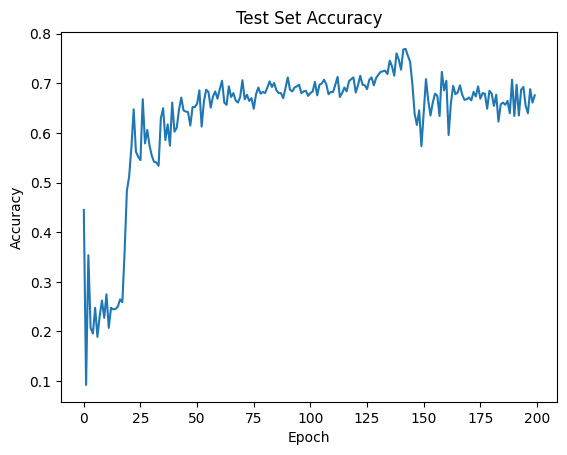

In [ ]:
# Plot Loss
fig = plt.figure(facecolor="w")
plt.plot(test_acc_hist)
plt.title("Test Set Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()